### ▶[Part1]. 데이터 준비
- 폴더별로 이미지를 준비함. 폴더명의 a,b,d.... 오름차순에 의하여 0,1,2,3의 레이블값이 제작됨

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras  # tesnforflow2는 고수준 API : 사용자가 control할 일이 별로 없음
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# 데이터 종류별 폴더
data_dir='c:/data/clothes_dataset'

In [3]:
# 필수사항은 아님. 폴더안의 자료 확인차임.
from glob import glob
folderList=glob(data_dir + '/*')
total=0

for folder  in folderList:
    print(folder)
    fileList=glob(folder + '/*' )
    # fileList=glob(folder + '/*.jpg' )
    print(len(fileList))
    total+=len(fileList)

print(total)

c:/data/clothes_dataset\black_dress
450
c:/data/clothes_dataset\black_pants
871
c:/data/clothes_dataset\black_shirt
715
c:/data/clothes_dataset\black_shoes
772
c:/data/clothes_dataset\black_shorts
429
c:/data/clothes_dataset\blue_dress
502
c:/data/clothes_dataset\blue_pants
798
c:/data/clothes_dataset\blue_shirt
741
c:/data/clothes_dataset\blue_shoes
773
c:/data/clothes_dataset\blue_shorts
557
c:/data/clothes_dataset\brown_pants
311
c:/data/clothes_dataset\brown_shoes
464
c:/data/clothes_dataset\brown_shorts
40
c:/data/clothes_dataset\green_pants
227
c:/data/clothes_dataset\green_shirt
230
c:/data/clothes_dataset\green_shoes
455
c:/data/clothes_dataset\green_shorts
135
c:/data/clothes_dataset\red_dress
800
c:/data/clothes_dataset\red_pants
308
c:/data/clothes_dataset\red_shoes
610
c:/data/clothes_dataset\white_dress
818
c:/data/clothes_dataset\white_pants
274
c:/data/clothes_dataset\white_shoes
600
c:/data/clothes_dataset\white_shorts
120
12000


###### numpy로 데이터가 들어온 것이 아니라면 무조건 이 과정을 거침
###### 모델 학습용 자료가 폴더에 있을 때는 이 작업을 실행 (npy 또는 npz로 있을 때는 곧바로 model.fit에 넣으면 됨)
### ▶[Part2.] Keras 유틸리티를 사용하여 데이터 로드하기
- 사용자가 설정한 배치크기만큼 x,y 데이터셋을 제작하는 과정
     - 이미지크기를 지정한 사이즈로 통일하고
     - x데이터를 세트로 array 시키고
     - y값은 폴더이름에 따라서 순차적으로 0,1,2,3....4를 부여함
     - 폴더이름을 class_names에 할당
- x,y값을 사용자가 지정한 비율에 맟추어서 train, test로 분리

In [4]:
batch_size = 32   # 배치 사이즈가 작을수록 속도라 느림
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,  #data_dir폴더를 훈련과 테스트로 나눌때만 필요한 코드
  subset="training",   #data_dir폴더를 훈련과 테스트로 나눌때만 필요한 코드
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,  #data_dir폴더를 훈련과 테스트로 나눌때만 필요한 코드
  subset="validation",    #data_dir폴더를 훈련과 테스트로 나눌때만 필요한 코드
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12000 files belonging to 24 classes.
Using 9600 files for training.
Found 12000 files belonging to 24 classes.
Using 2400 files for validation.


In [6]:
# 폴더명을 가져옴
class_names = train_ds.class_names
print(class_names)

['black_dress', 'black_pants', 'black_shirt', 'black_shoes', 'black_shorts', 'blue_dress', 'blue_pants', 'blue_shirt', 'blue_shoes', 'blue_shorts', 'brown_pants', 'brown_shoes', 'brown_shorts', 'green_pants', 'green_shirt', 'green_shoes', 'green_shorts', 'red_dress', 'red_pants', 'red_shoes', 'white_dress', 'white_pants', 'white_shoes', 'white_shorts']


In [7]:
################# 참고 [필수 아님]
# 총 12000개 자료
# validation_split=0.2  ==> 총 12000개중 80%는 train, 20%는 test
# train이 9600개이며, 이걸 배치사이즈로 묶으면 32개씩 300 ===> 300 개 묶음이 생김

len(list(train_ds))

300

In [11]:
################# 참고 [필수 아님]
list(train_ds)[0]     # 32개의 이미지와 레이블이 있는 300개중 1번 묶음(이미지, 레이블)
list(train_ds)[0][1]  # 레이블

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([ 5,  5,  0,  3,  1,  8, 14, 17, 15, 16, 20, 17,  6,  5, 20,  3, 16,
        3,  7,  1, 17,  5, 17,  8,  4,  2,  4, 17, 20, 15, 20,  1])>

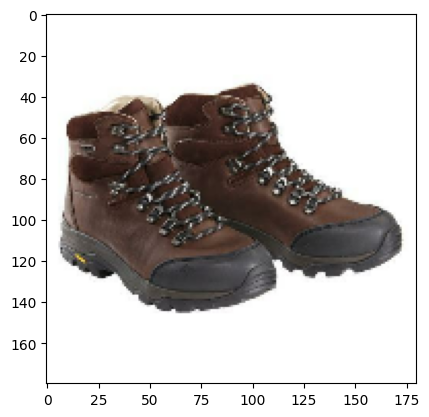

In [12]:
################# 참고 [필수 아님]
list(train_ds)[0][0] # 총 32개의 이미지
img=list(train_ds)[0][0][1].numpy().astype("uint8")
plt.imshow(img)


### ▶[Part3.] 모델 제작


In [35]:
# 성능을 높이도록 데이터세트 구성하기
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
## 증강 아래 내용외에 더 추가해도 됨  (아래의 사이트를 참조해서 다른 증강도 더 넣어도 되고, 또는 처음부터 이미지를 증강해서 준비해도 됨)
## https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [15]:
# ### 모델 제작

# num_classes = len(class_names)

# model = Sequential([
#   data_augmentation,
#   layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),      #모델안에 스케일링 넣어주면 새로운 데이터 넣어서 추론할때 스케일링을 하지 않아도 됨
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.2),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes, activation='relu')
# ])

In [38]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),      #모델안에 스케일링 넣어주면 새로운 데이터 넣어서 추론할때 스케일링을 하지 않아도 됨
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [39]:
model.summary()

# 파라미터 계산법
# layers.Rescaling(1./255, input_shape=(img_height, img_width, 3))
#   layers.Conv2D(16, 3, padding='same', activation='relu'),             ==> 3개의 input 채널임, 1개의 채널에는 3개의 커널사이즈가 있음. 즉 9개의 w값이 생성됨
#                                                                            1개채널당 9 * 3개채널 => 27개 + 바이어스1개 =>28개 --->  이런경우가 16개 있음 ===> 총 파람은 [28*16=448개]
#  layers.Conv2D(32, 3, padding='same', activation='relu'),              ==> 16개의 input 채널임, 1개의 채널당 9(커널사이즈가 가로3*세로3) 개의 w+1개 바이어스(10개) 
#                                                                            1개채널당 9* 16개채널 => 144개 + 바이어스1개 ==> 145개 --> 이런경우가 32개 있음 ==> 총 파람은 [145*32=4640]
# layers.Conv2D(64, 3, padding='same', activation='relu'),              ==> 32개의 input 채널임, 1개의 채널당 9 * 32개채널 + 바이어스 1 =>289개  * 64개 경우 ==> 총 파람은 [289*64=18496]
#   layers.Flatten()                                                    ==> 이미지사이즈 (22,22,64)를 모두 곱함.  30796
# layers.Dense(128, activation='relu'),                                 ==> 30976의 w + 1 개 b ===> 3977 * 128 = 3965056 파람
# layers.Dense(num_classes, activation='relu')                          ==> 128 의 w + 1개 b ==> 129*5=> 646개 파람

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 180, 180, 128)     3584      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 90, 90, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 90, 90, 256)       295168    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 45, 45, 256)      0         
 2D)                                                  

In [41]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

############### checkpoint ############### 
from tensorflow.keras.callbacks import ModelCheckpoint
modelpath="c:/data/model/clothes_classification/best_model/{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, verbose=1, save_best_only=True) #verbose기본값이 0임, 1을 지정하지 않으면 결과가 화면에 출력되지 않음

epochs=10
history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=[checkpointer]
)

Epoch 1/10
300/300 [==============================] - ETA: 0s - loss: 0.3906 - accuracy: 0.8776
Epoch 1: val_loss improved from inf to 0.44536, saving model to c:/data/model/clothes_classification/best_model\01-0.8708.hdf5
300/300 [==============================] - 34s 113ms/step - loss: 0.3906 - accuracy: 0.8776 - val_loss: 0.4454 - val_accuracy: 0.8708
Epoch 2/10
300/300 [==============================] - ETA: 0s - loss: 0.3535 - accuracy: 0.8873
Epoch 2: val_loss improved from 0.44536 to 0.40777, saving model to c:/data/model/clothes_classification/best_model\02-0.8808.hdf5
300/300 [==============================] - 34s 112ms/step - loss: 0.3535 - accuracy: 0.8873 - val_loss: 0.4078 - val_accuracy: 0.8808
Epoch 3/10
300/300 [==============================] - ETA: 0s - loss: 0.3343 - accuracy: 0.8939
Epoch 3: val_loss did not improve from 0.40777
300/300 [==============================] - 34s 112ms/step - loss: 0.3343 - accuracy: 0.8939 - val_loss: 0.5039 - val_accuracy: 0.8508
Epoch

In [42]:
import pandas as pd
hist_df=pd.DataFrame(history.history)
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.390604,0.877604,0.445355,0.870833
1,0.353499,0.887292,0.407773,0.880833
2,0.334318,0.893854,0.503929,0.850833
3,0.304607,0.898438,0.364195,0.892083
4,0.303299,0.900104,0.425819,0.892500


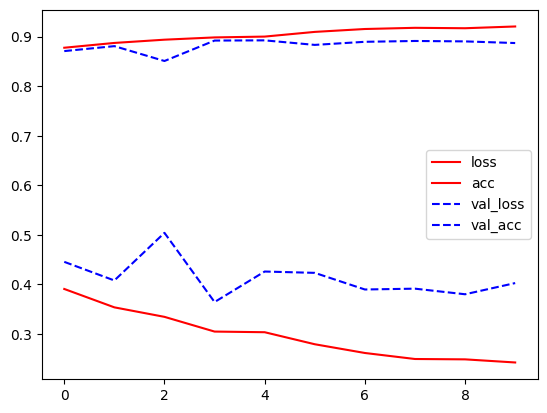

In [43]:
# y_vloss에 테스트셋(여기서는 검증셋)의 오차를 저장합니다.
y_vloss=hist_df['val_loss']

# y_loss에 학습셋의 오차를 저장합니다.
y_loss=hist_df['loss']

# x 값을 지정하고 테스트셋(검증셋)의 오차를 빨간색으로, 학습셋의 오차를 파란색으로 표시합니다.
plt.plot(hist_df['loss'],'r',label='loss')
plt.plot(hist_df['accuracy'],'r',label='acc')
plt.plot(hist_df['val_loss'],'--b',label='val_loss')
plt.plot(hist_df['val_accuracy'],'--b',label='val_acc')
plt.legend()

###  ▶[Part4.] 오차행렬표 검증표 제작

- 이 자료는 val_ds에서 배치단위로 데이터를 가져오기 때문에...

In [44]:
X_test,y_test=[],[]
for x, y in val_ds:
    # if len(y)==32:
    if len(y)==batch_size:    
        X_test.append(x.numpy())
        y_test.append(y.numpy())


X_test=np.reshape(X_test, (-1,180,180,3)) # 전체 데이터에 23개가 들어감
y_test=np.reshape(y_test,(-1))

In [45]:
# val_ds 734  734/32 = 23
list(val_ds)[0][1] , list(val_ds)[22][1]
# 개수가 맞지 않으므로 array append 시킬 때 list형으로 들어가게 됨 

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([ 8, 17,  7,  8, 19, 21,  2,  9,  1, 14,  0, 20, 20,  8, 20,  6,  5,
        20, 21,  2,  9, 22,  1, 20, 17,  8,  1, 11, 17,  6, 20,  0])>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([ 3, 13, 15, 16, 10, 17, 23,  4,  4, 19,  8, 20,  2,  7, 17,  7,  4,
        14,  4, 20,  7, 11, 18, 22,  4,  3, 17, 17, 20, 19, 11, 19])>)

In [46]:
test_yhat=model.predict(X_test)
# 소프트맥스일때 y값이 원핫인코딩 되어 있다면 아래의 과정1,2가 필요함()
predict_y=np.argmax(test_yhat, axis=1) # [과정1]
real_y=y_test.copy()  # 원핫인코딩 되어 있지 않음으로    

In [47]:
# 오차행렬표임 (교재 388쪽의 하단내용)
import pandas as pd
from sklearn.metrics import confusion_matrix
conMatrix=confusion_matrix(real_y, predict_y)
conMatrix

array([[ 82,   0,   2,   0,   1,   2,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1, 140,   5,   5,   1,   0,   5,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  7,   0, 140,   1,   2,   0,   0,   2,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  5,   7,   1, 132,   0,   0,   1,   0,   1,   1,   0,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   4,   0],
       [  1,   3,   4,   2,  76,   0,   0,   0,   0,   1,   0,   2,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  3,   0,   0,   0,   0,  96,   1,   0,   1,   1,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0],
       [  0,   5,   2,   1,   0,   4, 152,   3,   2,   1,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0],
       [  0,   0,   2,   1,   0,   4,   0

In [48]:
## 오차행렬 그래프를 그림으로 필수는 아님
pd.DataFrame(conMatrix)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,82,0,2,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,140,5,5,1,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,140,1,2,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,7,1,132,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,4,0
4,1,3,4,2,76,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,3,0,0,0,0,96,1,0,1,1,...,0,0,0,0,0,0,1,0,0,0
6,0,5,2,1,0,4,152,3,2,1,...,0,0,0,0,0,0,0,1,0,0
7,0,0,2,1,0,4,0,130,0,0,...,0,1,0,0,0,0,1,0,0,0
8,0,0,0,5,0,9,2,4,118,3,...,0,2,0,0,0,0,0,0,2,0
9,1,0,0,0,2,2,3,1,2,87,...,0,0,0,0,0,0,0,0,0,0


In [49]:
## 오차행렬 그래프를 그림으로 필수는 아님
# 오차행렬표를 데이터프레임으로 변환 (교재 388쪽 가장하단)
# 오차행렬표를 데이터프레임으로 작업하지 않고, 차트로 보여주는 모듈도 있음.
cnt=len(conMatrix)
pd.DataFrame(conMatrix, 
             index=['true_%d' % i for i in range(cnt)],
             columns=['pred_%d' % i for i in range(cnt)] )

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_14,pred_15,pred_16,pred_17,pred_18,pred_19,pred_20,pred_21,pred_22,pred_23
true_0,82,0,2,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
true_1,1,140,5,5,1,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
true_2,7,0,140,1,2,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
true_3,5,7,1,132,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,4,0
true_4,1,3,4,2,76,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
true_5,3,0,0,0,0,96,1,0,1,1,...,0,0,0,0,0,0,1,0,0,0
true_6,0,5,2,1,0,4,152,3,2,1,...,0,0,0,0,0,0,0,1,0,0
true_7,0,0,2,1,0,4,0,130,0,0,...,0,1,0,0,0,0,1,0,0,0
true_8,0,0,0,5,0,9,2,4,118,3,...,0,2,0,0,0,0,0,0,2,0
true_9,1,0,0,0,2,2,3,1,2,87,...,0,0,0,0,0,0,0,0,0,0


In [50]:
class_names[19]

'red_shoes'

Text(33.22222222222222, 0.5, 'true label')

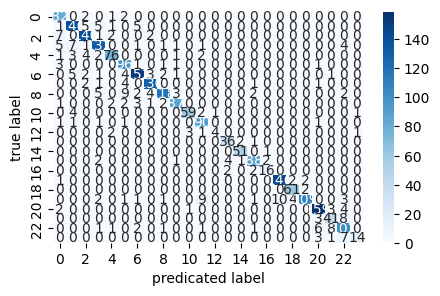

In [51]:
# 오차행렬표를 차트로 보여주는 작업_혼돈행렬
import seaborn as sns
plt.figure(figsize=(5,3))
sns.heatmap(conMatrix,annot=True, fmt='d',cmap='Blues')
plt.xlabel('predicated label')
plt.ylabel('true label')

In [52]:
from sklearn.metrics import classification_report
print(classification_report(real_y, predict_y))

              precision    recall  f1-score   support

           0       0.79      0.94      0.86        87
           1       0.88      0.89      0.88       157
           2       0.90      0.92      0.91       152
           3       0.86      0.86      0.86       153
           4       0.89      0.85      0.87        89
           5       0.81      0.93      0.86       103
           6       0.91      0.89      0.90       171
           7       0.93      0.94      0.93       139
           8       0.94      0.81      0.87       145
           9       0.92      0.89      0.90        98
          10       0.94      0.88      0.91        67
          11       0.85      0.95      0.90        95
          12       0.80      0.36      0.50        11
          13       0.86      0.92      0.89        39
          14       0.94      0.98      0.96        52
          15       0.92      0.90      0.91        98
          16       0.84      0.80      0.82        20
          17       0.94    

###  ▶[Part5.]새로운 데이터로 추론

In [53]:
# from PIL import Image
# import numpy as np
# img=Image.open('c:/data/a.jpg').resize((180,180)).convert('RGB')
# img=np.array(img)

# img=np.reshape(img, (1,180,180,3))
# result=model.predict(img)
# resultBun=np.argmax(result)
# class_names[resultBun]

 ▶[Part6.] 모델 저장

In [54]:
model.save('c:/data/model/clothes.h5')

In [55]:
# yhat=[]
# list(val_ds)[0]
# # len(list(val_ds)) = 22 
# for x,y in val_ds.take(22):  # 22개
#     for img in x: # x:32개
#         img=np.array(img)  # img.shape(180,180,3)
#         img=np.reshape(img,(1,180,180,3)) # reshape를 하지 않으면 error 발생
#         yhat.append(np.argmax(model.predict(img)))
